In [2]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import glob
%matplotlib inline


#import seaborn as sns
#sns.set(rc={"figure.figsize": (8, 8)})

In [3]:
#import matplotlib.pyplot as plt
home = os.getenv('HOME') #Ilan's home directory
plumes = os.getenv('PLUMES') #plumes data
cuip = os.getenv('CUIP')
csvs = 'output_csvs'


In [66]:
# %load label_copy.py
import scipy as sp
from scipy import ndimage
import pylab as pl
from skimage import filters
import csv


PLOT = False


def rebin(arr, new_shape):
    """Rebin 2D array arr to shape new_shape by averaging."""
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

def getregion(img, threshold):
    """Extract labeled objects from images and create new features using the output.
    Input 2D array (image), resize it using rebin and threshold filter it
    using the default threshold: Mean + 3*Std
    
    The output are five numbers
    """
    tmp2 = rebin(img, (img.shape[0]/4, img.shape[1]/4))

    imgtmp = tmp2.copy()
    if threshold == 'm3sd':
        imgtmp[tmp2<np.mean(tmp2) + 3.*np.std(tmp2)]=0
    elif threshold == 'm4sd':
        imgtmp[tmp2<np.mean(tmp2) + 4.*np.std(tmp2)]=0
        
    else:
        raise ValueError, 'Please specify a valid threshold'
    
    imgtmp[imgtmp>0]=1
    
    labels, n_features = ndimage.measurements.label(imgtmp)
    
    labelsize = np.array([(labels==i).sum() for i in range(labels.max()+1)])
    lbl_names = np.unique(labels)
    labs = np.unique(labelsize)
    labdiff = np.diff(np.unique(labelsize))
   
    mean_x = np.zeros(len(lbl_names[1:]))
    mean_y = np.zeros(len(lbl_names[1:]))    
    sdx = np.zeros(len(lbl_names[1:]))
    sdy = np.zeros(len(lbl_names[1:]))
    
    for i,j in enumerate(lbl_names[1:]):
        x,y = np.where(labels == j)
        #print i,len(x),len(y)
        
        mean_x[i] = x.mean()
        mean_y[i] = y.mean()
        sdx[i] = x.std()
        sdy[i] = y.std()
    
    
    top_idx = sorted(range(len(labelsize[1:])), key=lambda i: labelsize[1:][i], reverse=True)[:2]
    
    mx1,mx2 = mean_x[top_idx[0]],mean_x[top_idx[1]]
    my1,my2 = mean_y[top_idx[0]],mean_y[top_idx[1]]
    sdx1,sdx2 = sdx[top_idx[0]], sdx[top_idx[1]]
    sdy1,sdy2 = sdy[top_idx[0]], sdy[top_idx[1]]
   

    return(len(labs),np.max(labdiff[:-1]),(labdiff>=50).sum(),n_features,
           np.mean(labdiff[:-1]),
           sdx1,sdy1,sdx2,sdy2,mx1,my1,mx2,my2)


def create_csv(ifile_path, ofile_path, threshold):
    tmp = np.sort(glob.glob(ifile_path))
    csvfile = open(ofile_path,'w')
    col_names = ['image', 'n_patches','largest_patch','patch_50+_pix',
                 'n_features','mean_patch_size','sdx_largest',
                 'sdy_largest','sdx_2nd_largest','sdy_2nd_largest',
                'center_X_largest','center_Y_largest','center_X_2largest','center_Y_2largest']
    
    writer = csv.writer(csvfile, delimiter=',',lineterminator='\n')
    writer.writerow(col_names)
    for t in tmp:
        try:
            img = np.load(t)[200:1300,:,:].mean(-1)
        except:
            pass
        line = [t[68:]]
        line.extend(getregion(img, threshold))  
        writer.writerow(line)
    #csvfile.close()
    
if __name__ == '__main__':
    plot = PLOT
    plumes = os.getenv('PLUMES')
    imgpath = os.path.join(plumes,'outputs/tmp_0*_mindif.npy')

    create_csv(imgpath,'output_csvs/mean+4sd_mindif.csv', threshold = 'm4sd')


In [5]:
# %load read_and_roll.py
import scipy as sp
import numpy as np
import pandas as pd
from scipy import ndimage, signal
import matplotlib.pyplot as plt
#import seaborn as sns
import sys
#sns.set()



def read_and_plot(file_path, plot = False):
    """
    Take csv, clean it and plot all its features as subplots.
    Input is a data frame
    Return a Pandas Dataframe and the plot with plumes highlighted
    As default, no plot is generated, only the dataframe is returned
    """
    col_names = ['image', 'n_patches','2nd_largest_patch','patch_50+_pix','n_features','mean_patch_size', 'largest_patch']
    df = pd.read_csv(file_path, header = None, names=col_names)
    df.loc[:,'image'] = np.array([int(l[12:16].strip().split()[0]) for l in df.loc[:,'image']])
    df.index = df.image
    df.drop('image', axis = 1, inplace = True)

    if plot:
        ax = df.plot(subplots = True,figsize = (8,8), title = str(data_csv))
        df.iloc[135:155,:].plot(subplots = True, ax = ax, color = 'k', legend = False)
        plt.savefig(str.join(data_csv,'.pdf'))
        plt.show()
    
    return df

def roll_and_plot(data_column, window = 100, plot = False, table = False):
    """
    Calculate and plot the rolling mean and rolling standard deviation for given dataframe.
    Input for column and datafile should be a string object.
    Return: Rolling mean and std table and plot saved as a pdf
    Default value for the window is 100.
    Plot is returned as default.
    Set table=True to get the rolling data frame
    """
    
    unsmooth = data_column

    smooth = unsmooth.rolling(window = window, center = True, axis = 0).mean()
    smooth_sd = unsmooth.rolling(window = window, center = True, axis = 0).std()
    final = pd.DataFrame({'unsmooth':unsmooth, 'smooth':smooth, 'smooth_std':smooth_sd})
    
    if plot:
        ax = final.unsmooth.plot(figsize = (8,8), linestyle = 'none', marker = '.')
        final.unsmooth[135:155].plot(ax = ax, marker = '.', linestyle = 'none', c = 'y')
        
        final[['smooth', 'smooth_std']].plot(ax = ax)
        
        plt.title(str(' Rolling window' + window + 'images'), size = 15)
        plt.legend(['Images', 'Mean','St Dev', 'Plumes'], loc = 2)
        plt.ylabel(str(data_column.name + ' (Pixels)'), size = 13)
        plt.xlabel('Image', size = 13)
        plt.show()
        plt.savefig(str(data_column.name + '_roll.pdf'))
    
    if table:  
        return final
    

#if __name__ == '__main__':
    
#    df = read_and_plot(sys.argv[1], plot = False)
#    column = df[sys.argv[2]]
#    roll_and_plot(column, plot = True)
    
    


# Load the images

Once the images are loaded and saved into a text file they are ready to be plotted using the function read_and:plot as shown below for various cases.

In [32]:

#imgpath2 =  os.path.join(plumes,'outputs/tmp_01[345][0-9]_mindif.npy')
#print imgpath
#imglist2 = sorted(glob.glob(imgpath2))        
#print imglist
#empty array to catch read images

#imgs_min = np.zeros((nimgs, 1300, 4096))
#for i,f in enumerate(imglist2):
    #print(f)
    #imgs_min[i] = np.load(f)[200:1500,:,:].mean(-1)

imgpath1 =  os.path.join(plumes,'outputs/tmp_01[345][0-9]_median.npy')
imglist1 = sorted(glob.glob(imgpath1))
nimgs = len(imglist1)
imgs = np.zeros((nimgs, 1100, 4096))    
for i,f in enumerate(imglist1):
    
    imgs[i] = np.load(f)[200:1300,:,:].mean(-1)
    #writer.writerow([f[68:], getregion(imgs[i])])
    

## The file is loaded here.

A new feature is created, the one you proposed.

In [74]:
df = pd.read_csv('output_csvs/mean+3sd_median.csv', header = 0)
#idx = [i for i in range(5, df.shape[0] + 5)]
df.index = df.index + 5
#df.index.name = 'image'
#del df['image']

df['feat*pix50'] = df['n_features'] * df['patch_50+_pix']
df['mean*nps'] = df['mean_patch_size'] * df['n_patches']
df['mean*feat'] = df['mean_patch_size'] * df['n_features']
df['radius_1'] = np.sqrt(df.sdx_largest**2 + df.sdy_largest**2)
df['radius_2'] = np.sqrt(df.sdx_2nd_largest**2 + df.sdy_2nd_largest**2)
df['centroid_distance'] = np.sqrt((df.center_X_largest - df.center_X_2largest)**2 + (df.center_Y_largest - df.center_Y_2largest)**2)
#df['radius_ratios'] = df.radius_2 / df.radius_1

df['centroid_displ_X'] = np.gradient(df.center_X_largest)
df['centroid_displ_Y'] = np.gradient(df.center_Y_largest)
df['total_displacement'] = np.sqrt((df.center_X_largest-df.centroid_displ_X)**2 + (df.center_Y_largest-df.centroid_displ_Y)**2)


df.head()

,image,n_patches,largest_patch,patch_50+_pix,n_features,mean_patch_size,sdx_largest,sdy_largest,sdx_2nd_largest,sdy_2nd_largest,...,center_Y_2largest,feat*pix50,mean*nps,mean*feat,radius_1,radius_2,centroid_distance,centroid_displ_X,centroid_displ_Y,total_displacement
5,outputs/tmp_0005_median.npy,25,4,1,1628,1.304348,0.996351,3.745271,1.156172,3.728510,...,854.750000,1628,32.608696,2123.478261,3.875535,3.903655,832.883980,-128.743633,304.561969,438.676753
6,outputs/tmp_0006_median.npy,17,3,1,1678,1.200000,1.462363,1.629030,1.293495,1.269720,...,79.578947,1678,20.400000,2013.600000,2.189119,1.812545,253.630143,-42.261290,59.666774,295.034945
7,outputs/tmp_0007_median.npy,33,14,1,2033,1.580645,6.257795,2.383359,5.921490,1.991301,...,148.416667,2033,52.161290,3213.451613,6.696297,6.247345,7.944408,-0.011696,7.577694,183.593232
8,outputs/tmp_0008_median.npy,17,30,1,1622,4.133333,1.900524,3.431216,1.366663,2.458844,...,494.787879,1622,70.266667,6704.266667,3.922402,2.813127,151.297743,3.740351,-34.105088,385.164289
9,outputs/tmp_0009_median.npy,27,24,1,1539,2.240000,2.738641,1.998768,1.576923,2.276159,...,347.696970,1539,60.480000,3447.360000,3.390462,2.769040,277.652675,86.042735,-118.723443,198.866945


## Rolling window pandas

This were the first rolling windows which were not correct, this wa sonly the first attempt.

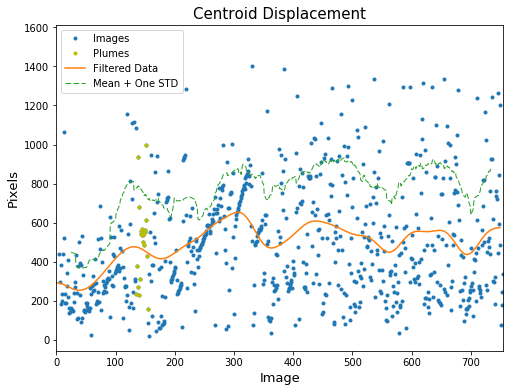

In [76]:
unsmooth = df.total_displacement

#smooth_g = unsmooth.rolling(window = 40, center = True, win_type = 'gaussian').mean(std = 20)
g = ndimage.filters.gaussian_filter(unsmooth, sigma = 20)
smooth_sd = unsmooth.rolling(window = 40, center = True).std()


final = pd.DataFrame({'unsmooth':unsmooth, 'smooth_std':smooth_sd})#,'smooth_g':smooth_g})
final['g+3sd'] = g + final.smooth_std   
#final['g-3sd'] = g - 3*final.smooth_std 
#final['sg3sd'] = final.smooth_g + final.smooth_std   


ax = final.unsmooth.plot(figsize = (8,6), linestyle = 'none', marker = '.')
final.unsmooth[130:150].plot(ax = ax, marker = '.', linestyle = 'none', c = 'y')
#final.smooth_g.plot()
plt.plot(g)
final['g+3sd'].plot(ax = ax, linestyle ='--', linewidth=1)
#final['g-3sd'].plot(ax = ax, linestyle ='--', linewidth=1)
#final.sg3sd.plot(ax = ax, linestyle = '--', linewidth = 1)

plt.title('Centroid Displacement', size = 15)
plt.legend(['Images','Plumes', 'Filtered Data', 'Mean + One STD'], loc = 0)
plt.ylabel('Pixels', size = 13)
plt.xlabel('Image', size = 13)


#plt.savefig('output_imgs/m3sd_median_centroid_disp.pdf')


,centroid_distance,radius_ratios
centroid_distance,1.000000,0.012776
radius_ratios,0.012776,1.000000


In [34]:
#sdx2,sdx1 = np.sort(SDX, order = -1)[-2:]
#SDX[-2:][0]
#sdx1 = SDX.argsort()[2:][1]

In [179]:
df2 = pd.read_csv('output_csvs/mean+4sd.csv', header = 0)
#idx = [i for i in range(5,df2.shape[0] + 5)]
df2.index = df2.index + 5
df2.index.name = 'image'
#df2.index = df['#image']
#del df2['#image']

df2['mean*nps'] = df2['mean_patch_size'] * df2['n_patches']
df2['mean*feat'] = df2['mean_patch_size'] * df2['n_features']
df2['radius_1'] = np.sqrt(df2.sdx_largest**2 + df2.sdy_largest**2)
df2['radius_2'] = np.sqrt(df2.sdx_2nd_largest**2 + df2.sdy_2nd_largest**2)
df2['centroid_distance'] = np.sqrt((df2.X_largest - df2.X_2largest)**2 + (df2.Y_largest - df2.Y_2largest)**2)
df2['radius_ratio'] = df2.radius_2/df2.radius_1
df2['centroid_displ_X'] = np.gradient(df2.X_largest)
df2['centroid_displ_Y'] = np.gradient(df2.Y_largest)
df2['total_displacement'] = np.sqrt((df2.X_largest-df2.centroid_displ_X)**2 + (df2.Y_largest-df2.centroid_displ_Y)**2)
df2[130:150]

,image,n_patches,largest_patch,patch_50+_pix,n_features,mean_patch_size,sdx_largest,sdy_largest,sdx_2nd_largest,sdy_2nd_largest,...,Y_2largest,mean*nps,mean*feat,radius_1,radius_2,centroid_distance,radius_ratio,centroid_displ_X,centroid_displ_Y,total_displacement
image,,,,,,,,,,,,,,,,,,,,,
135,outputs/tmp_0135_median.npy,15,7,1,553,1.846154,1.713009,1.953868,1.593716,2.046338,...,1008.750000,27.692308,1020.923077,2.598461,2.593729,763.541306,0.998179,60.801339,162.501488,104.692236
136,outputs/tmp_0136_median.npy,21,7,1,931,1.631579,1.446642,2.480392,1.048279,3.676351,...,856.133333,34.263158,1519.000000,2.871431,3.822884,381.895103,1.331352,89.626897,372.004828,186.332849
137,outputs/tmp_0137_median.npy,18,10,1,863,1.750000,1.273530,3.063731,0.986516,2.711465,...,628.928571,31.500000,1510.250000,3.317879,2.885352,387.798695,0.869637,-57.559103,-164.362772,1214.740923
138,outputs/tmp_0138_median.npy,20,3,1,830,1.222222,1.099923,2.224626,0.663325,2.657066,...,100.800000,24.444444,1014.444444,2.481691,2.738613,46.770647,1.103527,-58.662779,-460.815416,635.524453
139,outputs/tmp_0139_median.npy,16,11,1,587,2.357143,1.197243,2.543055,1.010867,2.563654,...,498.516129,37.714286,1383.642857,2.810786,2.755753,414.056081,0.980421,-29.571906,179.841137,186.278689
140,outputs/tmp_0140_median.npy,15,9,1,616,1.923077,1.153846,1.986642,1.909087,1.627969,...,714.043478,28.846154,1184.615385,2.297413,2.508963,208.293831,1.092082,56.036528,193.083491,313.032625
141,outputs/tmp_0141_median.npy,22,6,1,782,1.500000,1.567755,2.281902,0.684935,3.331275,...,513.703704,33.000000,1173.000000,2.768561,3.400960,48.753424,1.228421,68.848369,2.107531,504.903108
142,outputs/tmp_0142_median.npy,26,143,2,816,7.916667,3.935028,4.726528,1.462494,5.686088,...,471.958333,205.833333,6460.000000,6.150164,5.871157,53.313165,0.954634,-17.682377,19.962854,539.688878
143,outputs/tmp_0143_median.npy,18,190,2,366,14.375000,3.165997,9.293133,1.609387,2.577992,...,519.707317,258.750000,5261.250000,9.817630,3.039107,138.408121,0.309556,-1.756514,-0.368617,557.239356


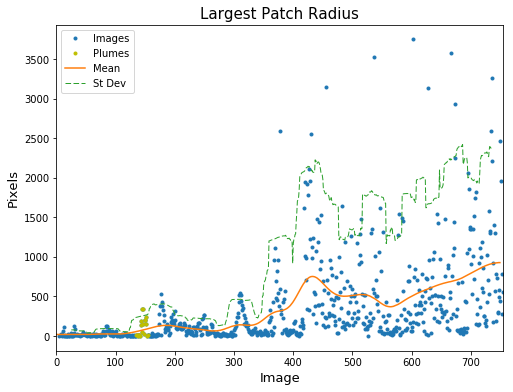

In [181]:
unsmooth = df2.largest_patch

smooth_g = unsmooth.rolling(window = 40, center = True, win_type = 'gaussian').mean(std = 20)
g = ndimage.filters.gaussian_filter(unsmooth, sigma = 20)
smooth_sd = unsmooth.rolling(window = 40, center = True).std()

final = pd.DataFrame({'unsmooth':unsmooth, 'smooth_g':smooth_g, 'smooth_std':smooth_sd})
final['g3sd'] = g + 2*final.smooth_std  
#final['g-3sd'] = g - final.smooth_std   
#final['sg3sd'] = final.smooth_g + 3*final.smooth_std   

ax = final.unsmooth.plot(figsize = (8,6), linestyle = 'none', marker = '.')
final.unsmooth[130:150].plot(ax = ax, marker = '.', linestyle = 'none', c = 'y')
#final.smooth_g.plot()
plt.plot(g)
final['g3sd'].plot(ax = ax, linestyle ='--', linewidth=1)
#final['g-3sd'].plot(ax = ax, linestyle = '--', linewidth = 1)

plt.title('Largest Patch Radius', size = 15)
plt.legend(['Images', 'Plumes', 'Mean','St Dev'], loc = 2)
plt.ylabel('Pixels', size = 13)
plt.xlabel('Image', size = 13)


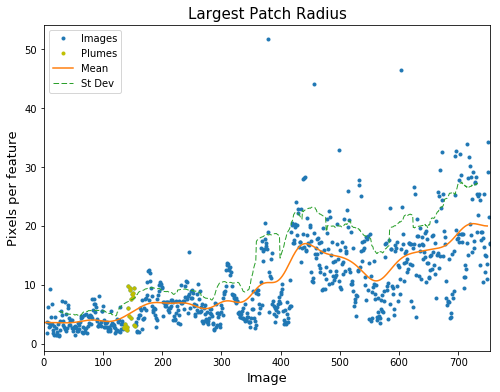

In [177]:
unsmooth = df2['radius_1']

#smooth_g = unsmooth.rolling(window = 40, center = True, win_type = 'gaussian').mean(std = 20)
g = ndimage.filters.gaussian_filter(unsmooth, sigma = 20)
smooth_sd = unsmooth.rolling(window = 40, center = True).std()

final = pd.DataFrame({'unsmooth':unsmooth, 'smooth_g':smooth_g, 'smooth_std':smooth_sd})
final['g3sd'] = g + final.smooth_std   
#final['sg3sd'] = final.smooth_g + 3*final.smooth_std   

ax = final.unsmooth.plot(figsize = (8,6), linestyle = 'none', marker = '.')
final.unsmooth[130:150].plot(ax = ax, marker = '.', linestyle = 'none', c = 'y')
#final.smooth_g.plot()
plt.plot(g)
final['g3sd'].plot(ax = ax, linestyle ='--', linewidth=1)
#final.sg3sd.plot(ax = ax, linestyle = '--', linewidth = 1)

plt.title('Largest Patch Radius', size = 15)
plt.legend(['Images', 'Plumes', 'Mean','St Dev'], loc = 2)
plt.ylabel('Pixels per feature', size = 13)
plt.xlabel('Image', size = 13)

In [79]:
tmp2 = rebin(imgs[14], (imgs[13].shape[0]/4, imgs[13].shape[1]/4))
imgtmp = tmp2.copy()
imgtmp[tmp2<np.mean(tmp2) + 3.*np.std(tmp2)]=0
imgtmp[imgtmp>0]=1

labels, n_features = ndimage.measurements.label(imgtmp)
labelsize =[(labels==i).sum() for i in range(labels.max()+1)]
lbl_names = np.unique(labels)

labs = np.unique(labelsize)
labdiff = np.diff(np.unique(labelsize))
#for i in labelsize
#np.where(labels == 421)
#np.std(x)
#np.std(
#X = []
#Y = []
SDX = np.zeros(len(lbl_names[1:]))
SDY = np.zeros(len(lbl_names[1:]))
MX = np.zeros(len(lbl_names[1:]))
MY = np.zeros(len(lbl_names[1:]))
for i,j in enumerate(lbl_names[1:]):
    x,y = np.where(labels == j)
    #print i,len(x),len(y)
    #X.append(x)
    #Y.append(y)
    MX[i] = x.mean()
    MY[i] = y.mean()
    SDX[i] = x.std()
    SDY[i] = y.std()
sdx2,sdx1 = np.sort(SDX)[-2:] 
top_idx = sorted(range(len(labelsize[1:])), key=lambda i: labelsize[1:][i], reverse=True)[:2]
mx1,mx2 = MX[top_idx[0]],MX[top_idx[1]]
mx1
#top_idx
#l = np.array([len(X[i]) for i in range(len(X))])    
#for i in range(len(X)):
#    l[i] = len(X[i])
#idx = np.where(l == labs.max())[0]

#labelsize
#max(SDX)


206.24060150375939

/gpfs1/cusp/ir729/.conda/envs/JupyterVE/lib/python2.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  from ipykernel import kernelapp as app
/home/cusp/ir729/.conda/envs/JupyterVE/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/cusp/ir729/.conda/envs/JupyterVE/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


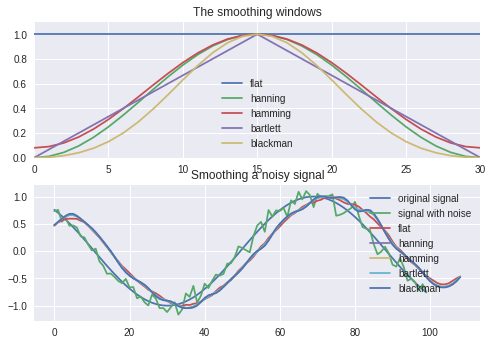

In [1354]:
def smooth_demo():

    t=linspace(-4,4,100)
    x=sin(t)
    xn=x+randn(len(t))*0.1
    y=smooth(x)

    ws=31

    subplot(211)
    plot(ones(ws))

    windows=['flat', 'hanning', 'hamming', 'bartlett', 'blackman']

    hold(True)
    for w in windows[1:]:
        eval('plot('+w+'(ws) )')

    axis([0,30,0,1.1])

    legend(windows)
    title("The smoothing windows")
    subplot(212)
    plot(x)
    plot(xn)
    for w in windows:
        plot(smooth(xn,10,w))
    l=['original signal', 'signal with noise']
    l.extend(windows)

    legend(l)
    title("Smoothing a noisy signal")
    show()

smooth_demo()